In [52]:
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pylab as plt
# %matplotlib tk
# %matplotlib nbagg
# %matplotlib inline
import h5py
import json
import pickle

## Loading files

In [53]:
filename_1 = Path("C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/2_Phase_A-D/20210127_Phase_A-D_LEM1.h5")
# filename_2 = Path("C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/2_Phase_A-D/20210127_Phase_A-D_LEM2.h5")

h51 = h5py.File(filename_1, "r")
# h52 = h5py.File(filename_2, "r")

print("ATTR:")
print(h51.attrs.keys())

print("Keys:")
print(h51.keys())

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>


In [54]:
json.loads(h51.attrs["name_lookup"])

{'Ist-Ablauf-Zeit, ca.': 't',
 'Ist-MG1: Teller-Drehfrequenz [Hz]': 'tdf',
 'Soll-MG1: Teller-Drehfrequenz [Hz]': 'stdf',
 'Ist-MG2: Kammer1-Temp[°C]': 'k1t',
 'Soll-MG2: Kammer1-Temp[°C]': 'sk1t',
 'Ist-MG3: Kammer1-Druck[bar]': 'k1p',
 'Soll-MG3: Kammer1-Druck[bar]': 'sk1p',
 'Ist-MG4: Kammer2-Temp.[°C]': 'k2t',
 'Soll-MG4: Kammer2-Temp.[°C]': 'sk2t',
 'Ist-MG5: Kammer2-Druck[bar]': 'k2p',
 'Soll-MG5: Kammer2-Druck[bar]': 'sk2p',
 'Ist-MG6: Kammer1-Kraft[kN]': 'k1f',
 'Soll-MG6: Kammer1-Kraft[kN]': 'sk1f',
 'Ist-MG7: Kammer2-Kraft[kN]': 'k2f',
 'Soll-MG7: Kammer2-Kraft[kN]': 'sk2f',
 'Ist-MG8: Kammer1-Außentemp.[°C]': 'k1at',
 'Soll-MG8: Kammer1-Außentemp.[°C]': 'sk1at',
 'Ist-MG9: Kammer2-Außentemp.[°C]': 'k2at',
 'Soll-MG9: Kammer2-Außentemp.[°C]': 'sk2at',
 'Ist-MG10: Kammer1-Istpos.[mm]': 'pos1',
 'Soll-MG10: Kammer1-Istpos.[mm]': 'spos1',
 'Ist-MG11: Kammer2-Istpos.[mm]': 'pos2',
 'Soll-MG11: Kammer2-Istpos.[mm]': 'spos2',
 'Ist-MG12: Hub1[mm]': 'hub1',
 'Soll-MG12: Hub1[mm]': '

In [55]:
shift_opts_freqs = pickle.load( open( "shift_opts_freqs.pkl", "rb" ) ) # calculated by grid search

In [56]:
%matplotlib nbagg
plt.plot(h51['phi'][:1000])

<IPython.core.display.Javascript object>

In [57]:
shift_opts_freqs.shape

(121, 46)

In [58]:
shift_opts_freqs[0].shape

(46,)

## Find the low speed areas

all low speed areas (low)

In [59]:
low = h51['spd1'][:]>-50
pos_low = h51['pos1'][low]

all low speed areas as ONE sequence

In [60]:
low = np.where(h51['spd1'][:]>-50)[0]
pos_low = h51['pos1'][low]

all low speed areas as seperate arrays

In [61]:
low_sep = np.where(np.diff(low)>10000)[0]
pos_low_sep = np.split(pos_low,low_sep+1)

cut out some points to make sure all points in low speed 
(if not some points in high speed area will showed up in s21, especially in later timestamps)

In [62]:
Ls = np.append(low[low_sep],low[-1])
# print("timestamps of Ls:")
# print (Ls)

Fs = np.append(low[0],low[low_sep+1])
# print("timestamps of Fs:")
# print (Fs)

# print("Durations of lsa:\n",Ls-Fs)

find the max values of positions in each low speed interval

In [63]:
# create a list of arrays max_sep, each array contains peak values of the corresponding low speed area.
max_sep = [] # (46,4)
for k in range(len(pos_low_sep)):
    # temporary sequency ts
    ts = pos_low_sep[k] 

    # find top 30 highest values
    max_20 = np.argsort(ts)[-30:][::-1]

    # filter the max value for each period
    temp =[max_20[0]]
    for i in max_20:
        if all([abs(j-i)>50 for j in temp]):        
            temp.append(i)
    max_sep.append(np.sort(temp))
    
# There should be 4 max values in each interval
assert all([len(max_sep[i])==4 for i in range(len(max_sep))]) 

## Data extraction

In [64]:
# # choose intervals with safe points (2000 points after the first peak value, 
# 2000 is to make sure no points in hsa are included, peak value is to make sure the same starting point for each interval)

features_setup = ['k1t',
                  'k1p',
                  'k1f',
                  'k1at',
                  #'phi',
                  'ip1k1',
                  'ip2k1']

# possible useful features
# hub1 constant
# tdf same as spd1?
ground_truths = ['pos1','spd1']

s21=[[] for _ in range(121)] # s21 for all frequendcies

pos1=[]
spd1=[]

k1t=[]
k1p=[]
k1f=[]
k1at=[]
# phi=[]
ip1k1=[]
ip2k1=[]

for i,Fc in enumerate(Fs):
    F = Fc + max_sep[i][0] 
    L = F + 2000
    for feature in features_setup:
        eval(feature).append(h51[feature][F:L])
    for gt in ground_truths:
        eval(gt).append(h51[gt][F:L])

for freq in range (121):
    FF = [F - shift for shift in shift_opts_freqs[freq]]
    LL = [L - shift for shift in shift_opts_freqs[freq]]
    for j in range(len(FF)):
        s21[freq].append(h51['S21_P1_LEM1'][FF[j]:LL[j], freq])

In [65]:
# calculated by grid search
shift_opts_freqs.shape

(121, 46)

In [66]:
shift_opts_freqs[0].shape

(46,)

In [67]:
np.array(pos1).shape

(46, 2000)

In [68]:
np.array(s21).shape

(121, 46, 2000)

In [69]:
shift_opts_freqs[20]

array([ 31,  37,  44,  51,  58,  64,  72,  79,  86,  93, 100, 106, 114,
       120, 128, 135, 143, 149, 157, 164, 171, 178, 185, 192, 199, 205,
       212, 219, 225, 232, 239, 247, 253, 260, 268, 275, 282, 288, 295,
       302, 309, 316, 322, 329, 337, 344])

In [70]:
# save the file as hdf5

file = r'C:\LINHC\VersucheDBs\Trelleborg\test\training.h5'

with h5py.File(file, 'w') as f:
    setup = f.create_group("setup")
    liview = f.create_group("liview")
    ref = f.create_group("ref")
    
    liview.create_dataset('s21',data=np.array(s21).reshape(121,-1))
    
    for feature in features_setup:
        tmp = np.array(eval(feature)).reshape(-1)
        setup.create_dataset(feature,data=tmp)
        
    for gt in ground_truths:
        tmp = np.array(eval(gt)).reshape(-1)
        ref.create_dataset(gt,data=tmp)

## Data preprocessing

normalize? imaginary number? 

In [71]:
## Read all the training data and labels from h5 files
with h5py.File(file, 'r') as f:
    y = np.asarray(f['ref']['pos1'])
    
    setup = f['setup']
    s21 = f['liview']['s21']
    
    dataset = []
    for i in range(121):
        dataset.append(s21[i].real)
        dataset.append(s21[i].imag)
    for value in setup.values():
        dataset.append(np.asarray(value))
    
    feature_lookup={}
    i = 242
    for key in setup.keys():
        feature_lookup[key] = i
        i += 1
        
X_train  = np.asarray(dataset).T

In [72]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

## Training

### NN

### RF

In [73]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor(n_estimators=10)
rfg.fit(X_scaled, y)

RandomForestRegressor(n_estimators=10)

In [76]:
importances = rfg.feature_importances_
indices = np.argsort(importances)[::-1]

In [77]:
print("Feature ranking:")
for f in range(X_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 245 (0.246004)
2. feature 1 (0.181281)
3. feature 246 (0.155240)
4. feature 4 (0.119564)
5. feature 247 (0.069474)
6. feature 51 (0.063601)
7. feature 57 (0.028713)
8. feature 244 (0.027203)
9. feature 10 (0.014964)
10. feature 101 (0.012716)
11. feature 13 (0.009132)
12. feature 9 (0.005144)
13. feature 109 (0.003827)
14. feature 8 (0.003337)
15. feature 14 (0.002108)
16. feature 102 (0.001844)
17. feature 103 (0.001748)
18. feature 242 (0.001700)
19. feature 32 (0.001444)
20. feature 18 (0.001384)
21. feature 35 (0.001241)
22. feature 2 (0.001027)
23. feature 135 (0.001021)
24. feature 131 (0.000845)
25. feature 80 (0.000817)
26. feature 127 (0.000817)
27. feature 134 (0.000795)
28. feature 38 (0.000745)
29. feature 41 (0.000714)
30. feature 52 (0.000706)
31. feature 95 (0.000687)
32. feature 243 (0.000664)
33. feature 111 (0.000653)
34. feature 81 (0.000612)
35. feature 100 (0.000600)
36. feature 19 (0.000598)
37. feature 0 (0.000598)
38. feature 133 (0.0

In [78]:
feature_lookup

{'ip1k1': 242, 'ip2k1': 243, 'k1at': 244, 'k1f': 245, 'k1p': 246, 'k1t': 247}

<IPython.core.display.Javascript object>


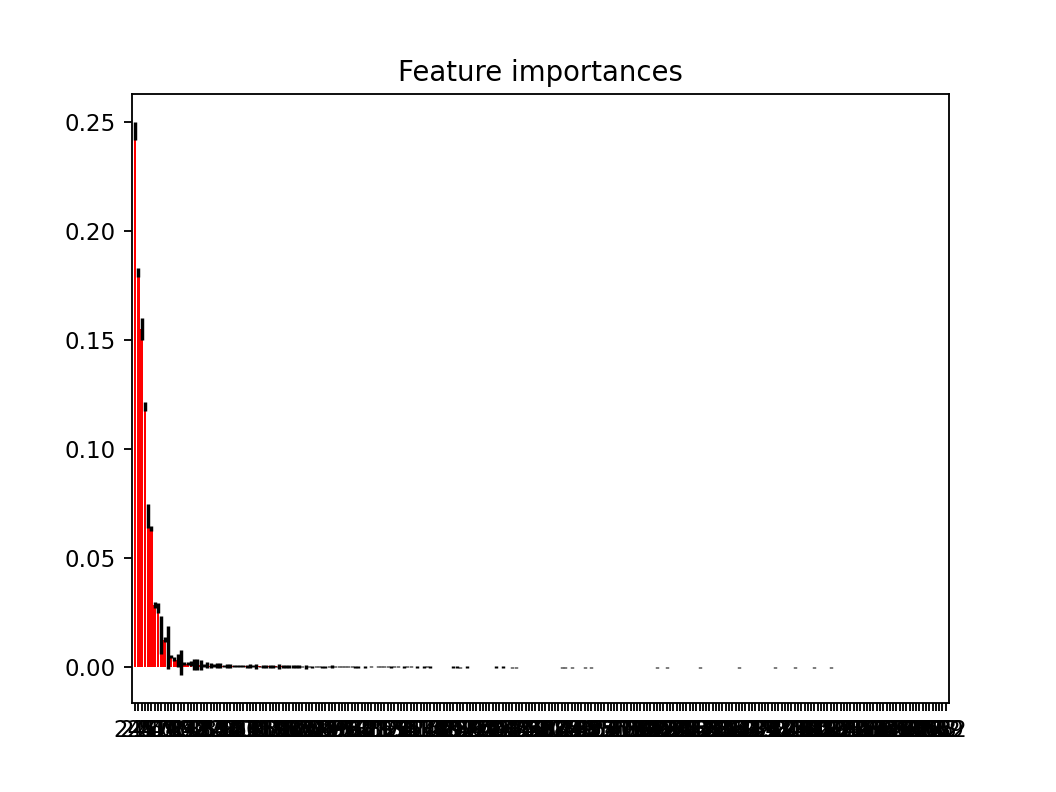

In [79]:
std = np.std([tree.feature_importances_ for tree in rfg.estimators_], axis=0)
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_scaled.shape[1]), indices)
plt.xlim([-1, X_scaled.shape[1]])
plt.show()